# Statistics and Optimization: Multiple Linear Regression

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from scipy import stats

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
# Set the random seed
np.random.seed(23373385)

In [3]:
# Load the dataset
data = pd.read_csv("mlr5.csv")

In [4]:
# Check structure of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1000 non-null   float64
 1   x1      1000 non-null   float64
 2   x2      1000 non-null   float64
 3   x3      1000 non-null   object 
dtypes: float64(3), object(1)
memory usage: 31.4+ KB


In [5]:
# Convert 'x3' to a categorical variable
data['x3'] = data['x3'].astype('category')

In [6]:
# Summary statistics for numerical variables
data.describe()

,y,x1,x2
count,1000.000000,1000.000000,1000.000000
mean,15397.667697,49.862441,200.114288
std,1688.386506,4.392076,5.146917
min,7495.862470,24.906049,183.188930
25%,14531.474328,48.044038,196.589304
50%,15414.254950,50.038341,200.157822
75%,16340.051520,51.875176,203.581602
max,23412.846094,67.043130,220.523128


In [7]:
# Frequency counts for the categorical variable 'x3'
data['x3'].value_counts()

x3
B    412
A    306
C    282
Name: count, dtype: int64

### Exploratory Data Analysis (EDA)

In [8]:
# Set the style for the plots
sns.set_style("whitegrid")

# Create a color palette with shades of blue
green_palette = sns.color_palette("Greens", 6)

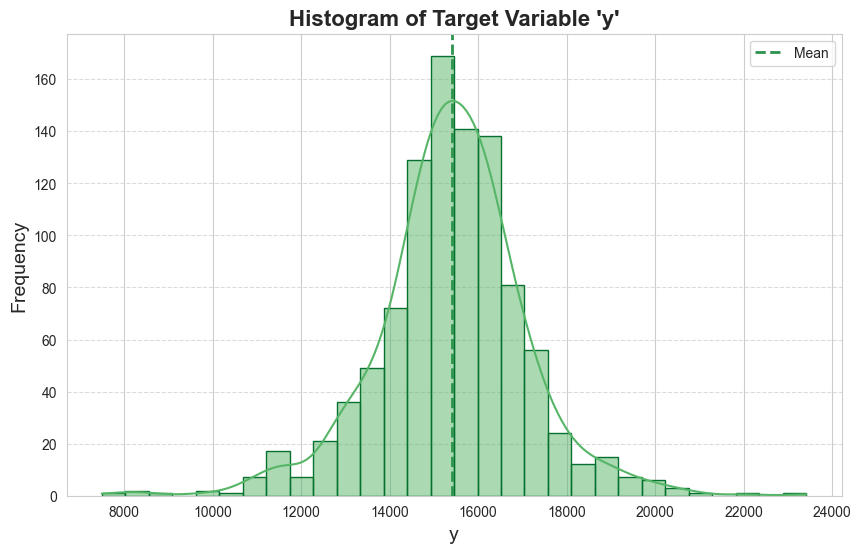

In [9]:
# Visualize distribution of target variable 'y'
plt.figure(figsize=(10, 6))
sns.histplot(data['y'], bins=30, kde=True, color=green_palette[3], edgecolor=green_palette[5])
plt.title("Histogram of Target Variable 'y'", fontsize=16, fontweight='bold')
plt.xlabel("y", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(data['y'].mean(), color=green_palette[4], linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.show()

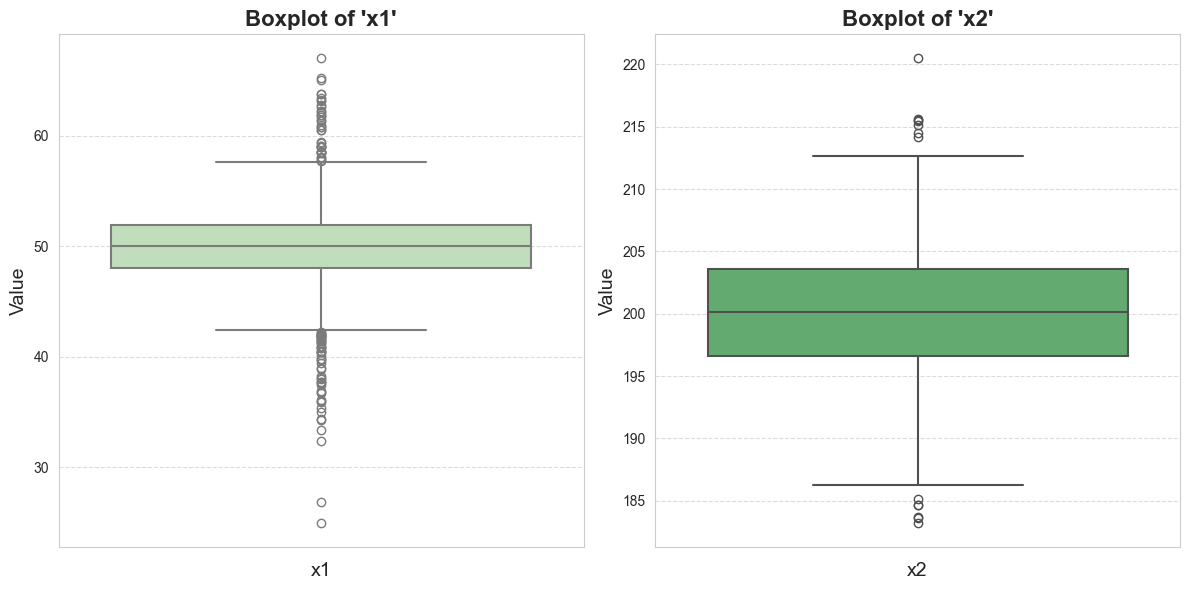

In [10]:
# Boxplots for checking outliers
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for 'x1'
sns.boxplot(data['x1'], ax=axs[0], color=green_palette[1], fliersize=6, linewidth=1.5)
axs[0].set_title("Boxplot of 'x1'", fontsize=16, fontweight='bold')
axs[0].set_ylabel("Value", fontsize=14)
axs[0].set_xlabel("x1", fontsize=14)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot for 'x2'
sns.boxplot(data['x2'], ax=axs[1], color=green_palette[3], fliersize=6, linewidth=1.5)
axs[1].set_title("Boxplot of 'x2'", fontsize=16, fontweight='bold')
axs[1].set_ylabel("Value", fontsize=14)
axs[1].set_xlabel("x2", fontsize=14)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

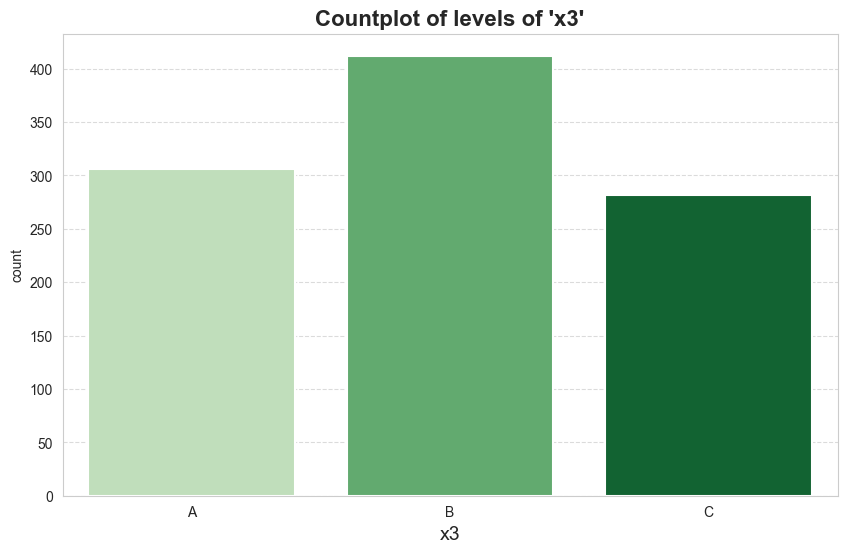

In [11]:
# Boxplot of 'y' by the levels of the categorical variable 'x3'
plt.figure(figsize=(10, 6))
sns.countplot(x=data['x3'], hue=data['x3'], palette=green_palette[1::2], linewidth=1.5)
plt.title("Countplot of levels of 'x3'", fontsize=16, fontweight='bold')
plt.xlabel("x3", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

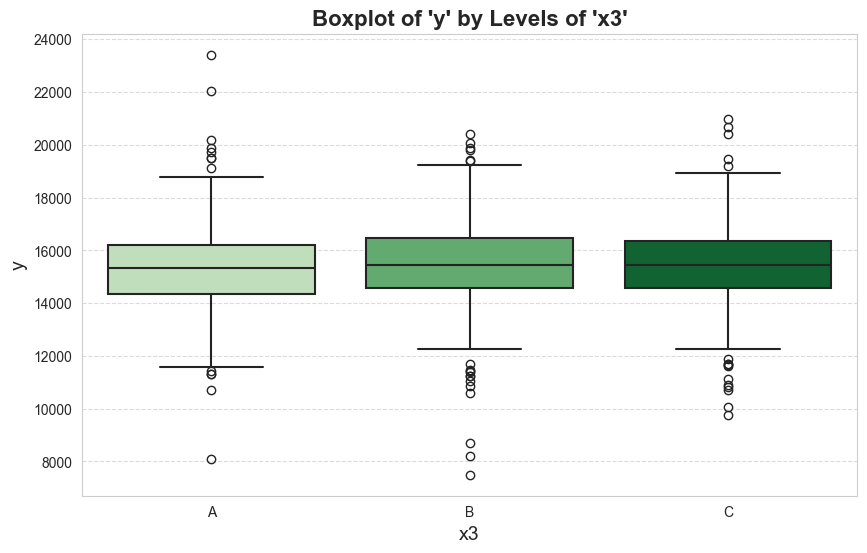

In [12]:
# Boxplot of 'y' by the levels of the categorical variable 'x3'
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['x3'], y=data['y'], hue=data['x3'], palette=green_palette[1::2], linewidth=1.5)
plt.title("Boxplot of 'y' by Levels of 'x3'", fontsize=16, fontweight='bold')
plt.xlabel("x3", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

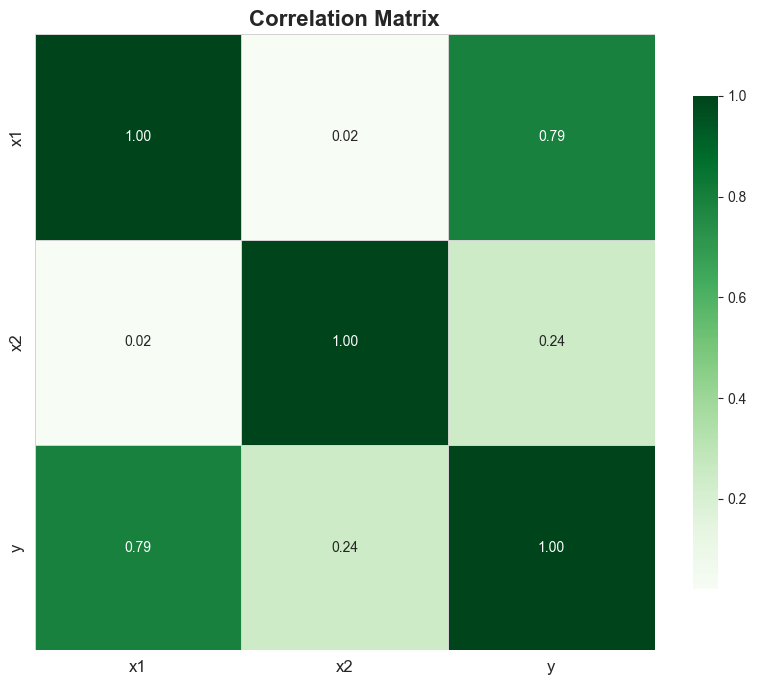

In [13]:
# Correlation plot for numeric variables
corr_matrix = data[['x1', 'x2', 'y']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt='.2f', 
            linewidths=0.5, linecolor='lightgrey', cbar_kws={"shrink": .8})

plt.title("Correlation Matrix", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

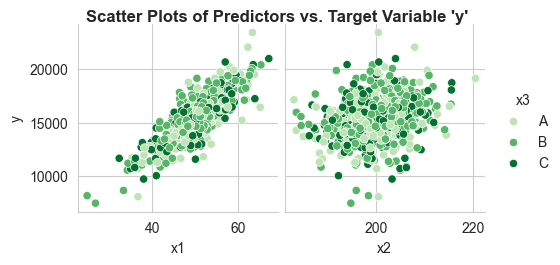

In [14]:
# Scatter plots for relationships between predictors and target variable
pairplot = sns.pairplot(data, x_vars=['x1', 'x2'], y_vars='y', hue='x3', palette=green_palette[1::2])

# Enhance titles and aesthetics
pairplot.figure.suptitle("Scatter Plots of Predictors vs. Target Variable 'y'", y=1.02, fontsize=12, fontweight='bold')

plt.show()


### Regression Implementation

In [15]:
# One-hot encode categorical columns
data = pd.get_dummies(data, columns=['x3'], drop_first=True, dtype='int')

In [16]:
data.head()

,y,x1,x2,x3_B,x3_C
0,14923.334339,48.802933,202.174619,0,1
1,19135.656602,50.371700,195.965649,1,0
2,15372.800047,52.618043,197.968019,0,0
3,15626.595082,48.765178,197.876746,1,0
4,18134.044214,58.961021,199.903762,1,0


In [17]:
# Set up input and target variables
X = data.drop(columns=['y'])
y = data['y']

In [18]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23373385)

# Check the structure of the split datasets
print(f"Training data size:\nX_train: {X_train.shape}\ty_train: {y_train.shape}\n")
print(f"Testing data size:\nX_test: {X_test.shape}\ty_test: {y_test.shape}")

Training data size:
X_train: (800, 4)	y_train: (800,)

Testing data size:
X_test: (200, 4)	y_test: (200,)


In [19]:
# Add a constant term for the intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [20]:
# Build Multiple Linear Regression model
mlr_model = sm.OLS(y_train, X_train).fit()

In [21]:
# Display summary of the model
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     420.1
Date:                Fri, 29 Nov 2024   Prob (F-statistic):          2.24e-194
Time:                        21:59:33   Log-Likelihood:                -6630.9
No. Observations:                 800   AIC:                         1.327e+04
Df Residuals:                     795   BIC:                         1.330e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.352e+04   1377.856     -9.815      0.000   -1.62e+04   -1.08e+04
x1           303.8764      7.715     39.389      0.000     288.733     319.020
x2            67.9901      6.672     10.190      0.000      54.892      81.088
x3_B         229.0012     82.838      2.764      0.006      66.394     391.608
x3_C         176.4230     89.514      1.971      0.049       0.711     352.135
==============================================================================
Omnibus:                       60.761   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.605
Skew:                          -0.345   Prob(JB):                     6.05e-40
Kurtosis:                       5.223   Cond. No.                     8.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression Diagnostics

In [22]:
# Check residuals of the model
residuals = mlr_model.resid
fitted_values = mlr_model.fittedvalues

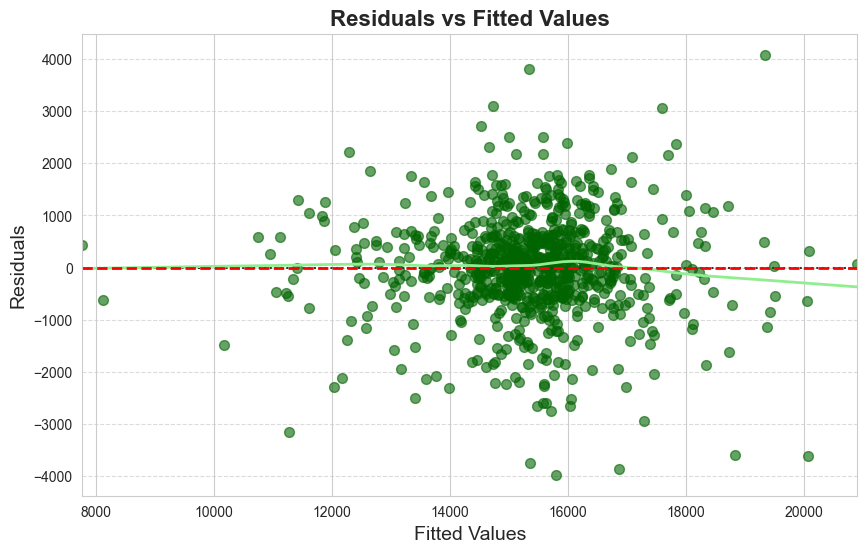

In [23]:
# Plot Residuals vs Fitted values
plt.figure(figsize=(10, 6))
# Residual plot with a lowess smoothing line
sns.residplot(x=fitted_values, y=residuals, lowess=True, color='darkgreen', 
               scatter_kws={'s': 50, 'alpha': 0.6}, line_kws={'color': 'lightgreen', 'lw': 2})
# Horizontal line at zero
plt.axhline(0, linestyle='--', color='red', linewidth=2)
# Enhancing title and labels
plt.title("Residuals vs Fitted Values", fontsize=16, fontweight='bold')
plt.xlabel("Fitted Values", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

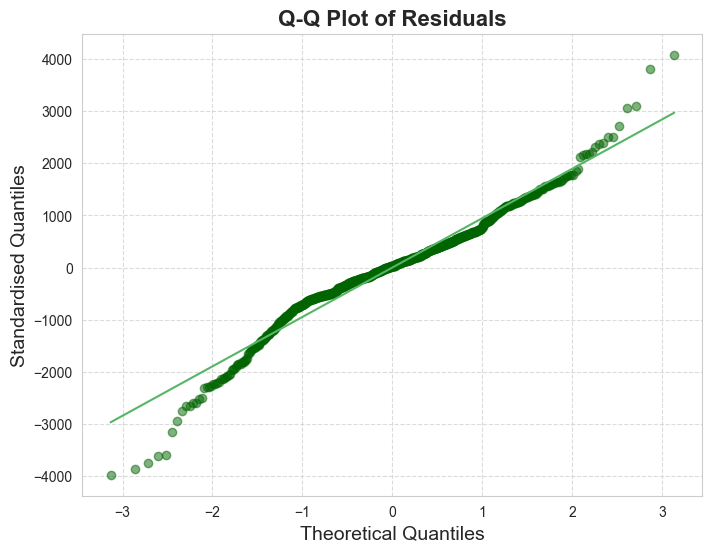

In [24]:
plt.figure(figsize=(8,6))

# Create the Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.gca().get_lines()[0].set_color('darkgreen')
plt.gca().get_lines()[0].set_alpha(0.5)
plt.gca().get_lines()[1].set_color(green_palette[3])

plt.title("Q-Q Plot of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Standardised Quantiles", fontsize=14)

plt.grid(linestyle='--', alpha=0.7)

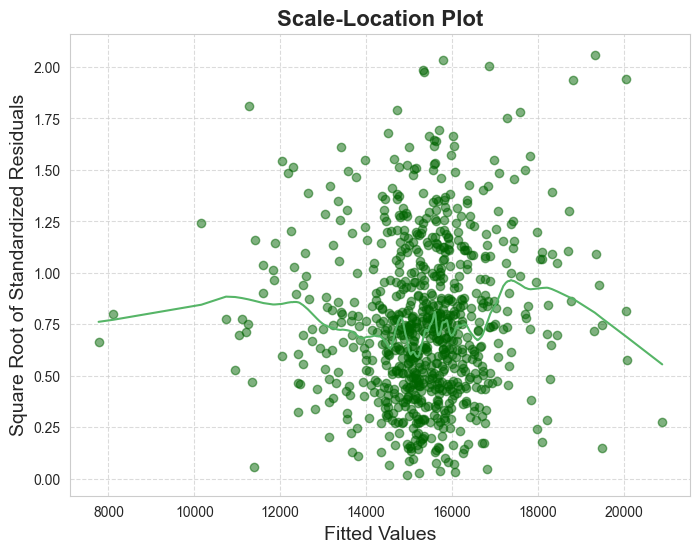

In [25]:
# Standardize the residuals and take the square root
standardized_residuals = residuals / np.std(residuals)
root_residuals = np.sqrt(np.abs(standardized_residuals))

# Perform LOESS smoothing on the fitted values and residuals
loess = lowess(root_residuals, fitted_values, frac=0.1)  # 'frac' controls the smoothness

plt.figure(figsize=(8, 6))

# Scatter plot of fitted values vs. square root of standardized residuals
plt.scatter(fitted_values, root_residuals, color='darkgreen', alpha=0.5)
# Plot the LOESS line
plt.plot(loess[:, 0], loess[:, 1], color=green_palette[3], label='LOESS')

plt.title("Scale-Location Plot", fontsize=16, fontweight='bold')
plt.xlabel("Fitted Values", fontsize=14)
plt.ylabel("Square Root of Standardized Residuals", fontsize=14)

plt.grid(linestyle='--', alpha=0.7)

In [26]:
# Calculate studentized residuals
influence = OLSInfluence(mlr_model)
studentised_residuals = influence.resid_studentized_internal

# Calculate leverage values
leverage = influence.hat_matrix_diag

# Calculate Cook's distances
cooks_distances = influence.cooks_distance[0]

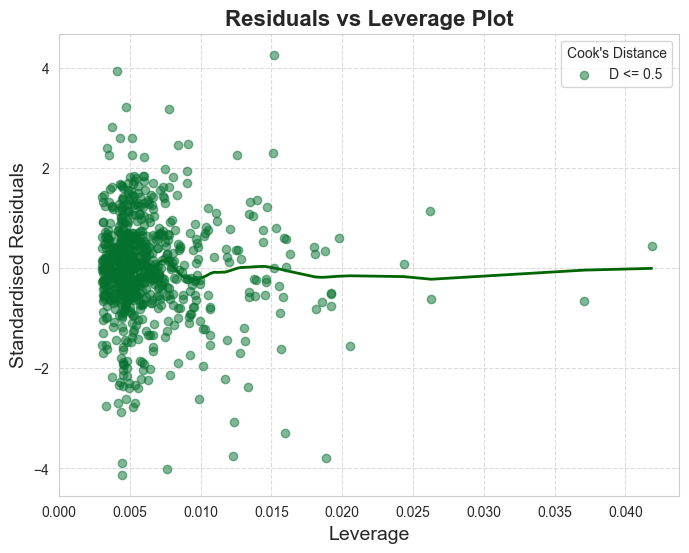

In [27]:
# Perform LOESS smoothing
loess = lowess(studentised_residuals, leverage, frac=0.1)  # Adjust 'frac' as needed

plt.figure(figsize=(8, 6))

# Plot observations with Cook's distance <= 0.5
mask1 = cooks_distances <= 0.5
plt.scatter(np.array(leverage)[mask1], np.array(studentised_residuals)[mask1], 
            color=green_palette[5], label="D <= 0.5", zorder=5, alpha=0.5)

# Plot observations with Cook's distance > 0.5 and < 1
mask2 = (cooks_distances > 0.5) & (cooks_distances < 1)
plt.scatter(np.array(leverage)[mask2], np.array(studentised_residuals)[mask2], 
            color=green_palette[3], zorder=5)

# Plot observations with Cook's distance >= 1
mask3 = cooks_distances >= 1
plt.scatter(np.array(leverage)[mask3], np.array(studentised_residuals)[mask3], 
            color=green_palette[1], zorder=5)

# Plot the LOESS line
plt.plot(np.sort(leverage), loess[:, 1], color='darkgreen', lw=2)

# Set the x-axis to start at zero
plt.xlim(0, None)

# Set chart and axis titles
plt.title("Residuals vs Leverage Plot", fontsize=16, fontweight='bold')
plt.xlabel("Leverage", fontsize=14)
plt.ylabel("Standardised Residuals", fontsize=14)

# Add a legend
plt.legend(title="Cook's Distance")

# Adding a grid for better readability
plt.grid(linestyle='--', alpha=0.7)

### Diagnostic Tests

In [28]:
# Statistical tests for diagnostics
report = "The test statistic is {:.3f}. The p-value is {:.3f}."

In [29]:
# 1. Normality of residuals using the Shapiro-Wilk test
print("Shapiro-Wilk test for normality")
statistic, pvalue = stats.shapiro(residuals)
print(report.format(statistic, pvalue))

Shapiro-Wilk test for normality
The test statistic is 0.965. The p-value is 0.000.


In [30]:
# 2. Homoscedasticity using Breusch-Pagan test
print("Breusch-Pagan test for Homoscedasticity")
statistic, pvalue, fstat, fpvalue = sms.het_breuschpagan(residuals, sm.add_constant(X_train))
print(report.format(statistic, pvalue))

Breusch-Pagan test for Homoscedasticity
The test statistic is 8.779. The p-value is 0.067.


In [31]:
# 3. Durbin-Watson test for autocorrelation in residuals
dw_stat = durbin_watson(residuals)
print("Durbin-Watson test statistic:", dw_stat)

Durbin-Watson test statistic: 1.8998287320932055


In [32]:
# 4. Multicollinearity check using Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)

  Variable          VIF
0    const  1628.859002
1       x1     1.004993
2       x2     1.007211
3     x3_B     1.429350
4     x3_C     1.422690


### Model Predictions

In [33]:
y_pred = mlr_model.predict(X_test)

In [34]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 650.2898172487227
MSE: 777505.873827278
RMSE: 881.7629351630052


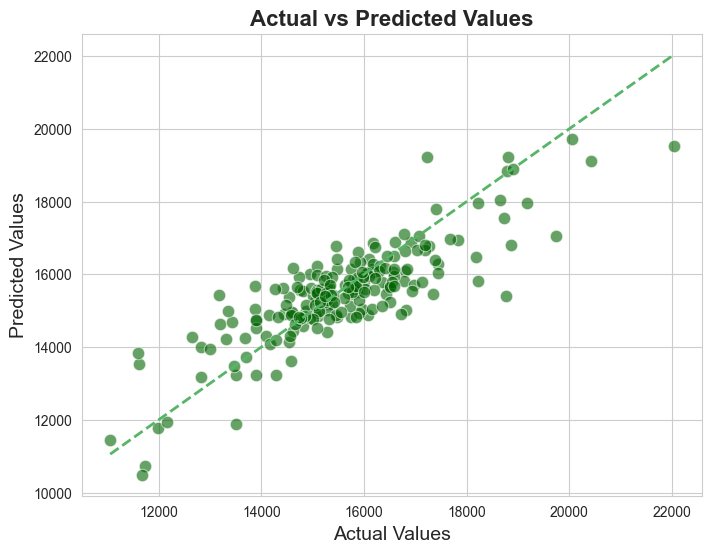

In [35]:
# Plot actual vs predicted values
plt.figure(figsize=(8,6))

# Scatter plot for actual vs predicted values
sns.scatterplot(x=y_test, y=y_pred, color='darkgreen', alpha=0.6, s=80, edgecolor='w')

# Add a reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color=green_palette[3], linestyle='--', linewidth=2)

# Enhancing title and labels
plt.title("Actual vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)

# Adding grid lines for better readability
plt.grid(True)

plt.show()